In [37]:
# libs

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from kerastuner.tuners import RandomSearch
import seaborn as sns

from scipy import stats

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


import warnings
warnings.filterwarnings('ignore')



## 1. Load the data

In [3]:
original_df = pd.read_csv('data/XAU_15m_data_2004_to_2024-20-09.csv')

original_df.head()


,Date,Time,Open,High,Low,Close,Volume
0,2004.06.11,07:15,384.0,384.3,383.8,384.3,12
1,2004.06.11,07:30,383.8,384.3,383.6,383.8,12
2,2004.06.11,07:45,383.3,383.8,383.3,383.8,20
3,2004.06.11,08:00,383.8,384.1,383.6,383.6,8
4,2004.06.11,08:15,383.6,384.3,383.5,383.5,20


In [4]:
# clean the data
original_df['Datetime'] = pd.to_datetime(original_df['Date'] + ' ' + original_df['Time'])
original_df.drop(['Date', 'Time'], axis=1, inplace=True)
original_df

,Open,High,Low,Close,Volume,Datetime
0,384.00,384.30,383.80,384.30,12,2004-06-11 07:15:00
1,383.80,384.30,383.60,383.80,12,2004-06-11 07:30:00
2,383.30,383.80,383.30,383.80,20,2004-06-11 07:45:00
3,383.80,384.10,383.60,383.60,8,2004-06-11 08:00:00
4,383.60,384.30,383.50,383.50,20,2004-06-11 08:15:00
...,...,...,...,...,...,...
464732,2587.32,2587.63,2587.03,2587.30,903,2024-09-20 01:30:00
464733,2587.27,2587.84,2586.95,2587.71,710,2024-09-20 01:45:00
464734,2587.71,2587.77,2587.31,2587.47,1105,2024-09-20 02:00:00
464735,2587.45,2587.74,2586.37,2587.04,1748,2024-09-20 02:15:00


## 2. EDA

In [5]:
df = original_df.copy()

In [34]:
print("Basic Statistical Description:")
print(df.describe())


Basic Statistical Description:
                Open           High            Low         Close  \
count  464737.000000  464737.000000  464737.000000  464737.00000   
mean     1307.116626    1307.968012    1306.245648    1307.11676   
std       469.786215     470.059334     469.506512     469.79050   
min       381.300000     381.600000     381.100000     381.30000   
25%      1002.260000    1003.100000    1001.410000    1002.30000   
50%      1287.110000    1287.750000    1286.470000    1287.11000   
75%      1693.150000    1694.300000    1692.080000    1693.14000   
max      2594.160000    2600.000000    2591.220000    2594.18000   

              Volume        Returns  
count  464737.000000  464736.000000  
mean      852.995143       0.000005  
std      1069.354264       0.001151  
min         1.000000      -0.049731  
25%       170.000000      -0.000429  
50%       584.000000       0.000000  
75%      1148.000000       0.000443  
max     50244.000000       0.040247  


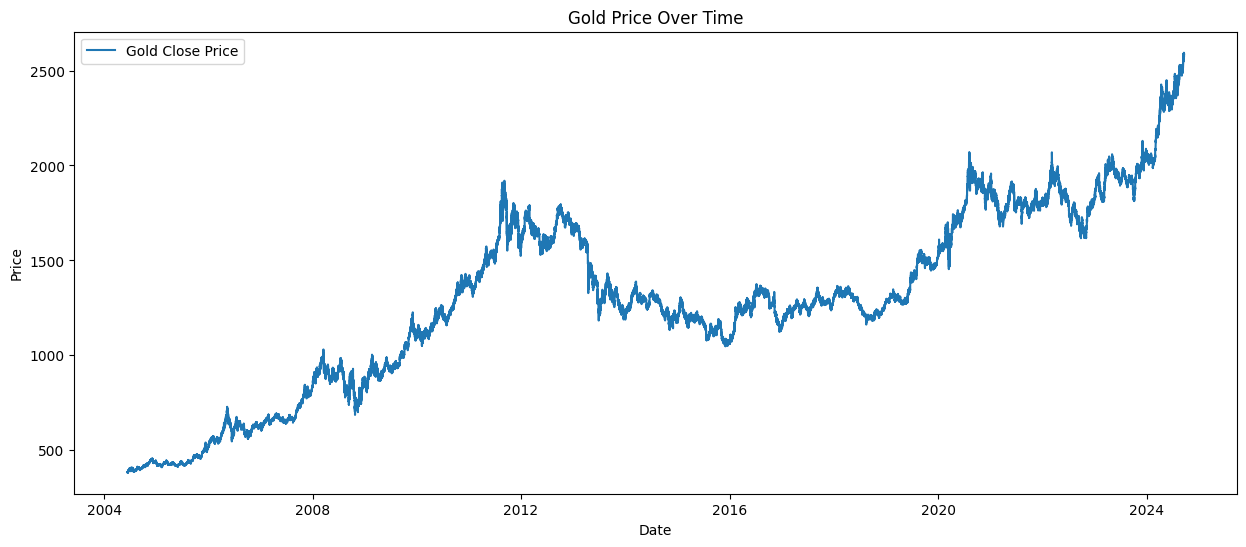

In [7]:
plt.figure(figsize=(15, 6))
plt.plot(df['Datetime'], df['Close'], label='Gold Close Price')
plt.title('Gold Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

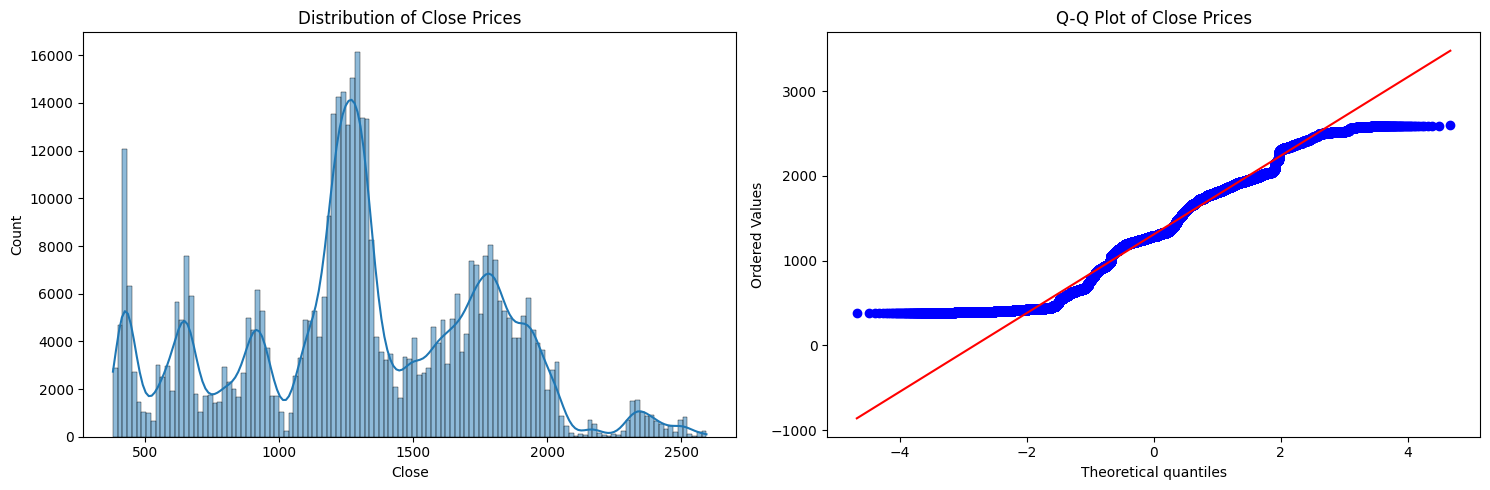

In [35]:
# 3. Price Distribution Analysis
plt.figure(figsize=(15, 5))

# Close Price Histogram
plt.subplot(1, 2, 1)
sns.histplot(df['Close'], kde=True)
plt.title('Distribution of Close Prices')

# Q-Q Plot
plt.subplot(1, 2, 2)
stats.probplot(df['Close'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Close Prices')
plt.tight_layout()
plt.show()


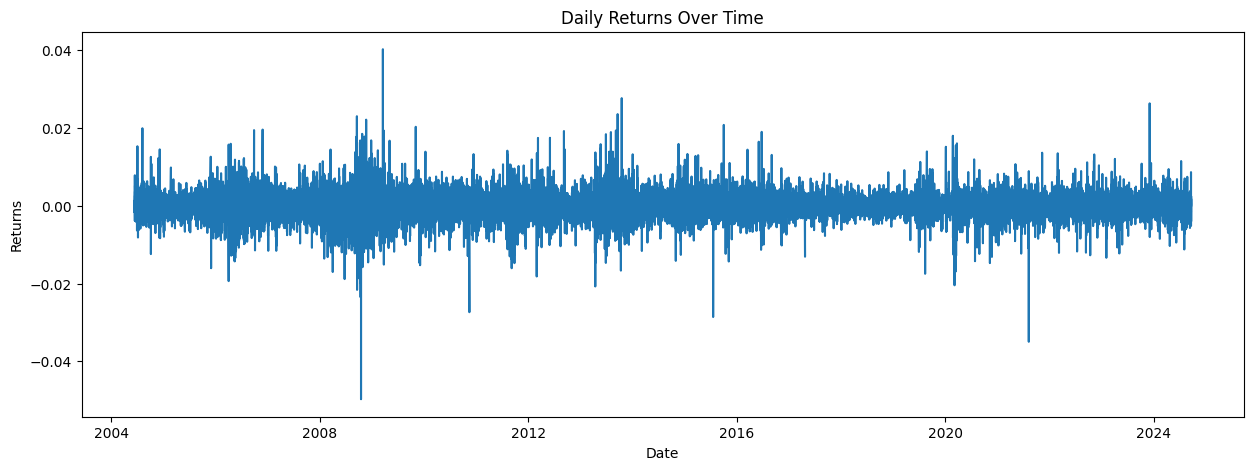

In [36]:
# 4. Price Volatility Analysis
# Calculate Daily Returns
df['Returns'] = df['Close'].pct_change()

plt.figure(figsize=(15, 5))
plt.plot(df.index, df['Returns'])
plt.title('Daily Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.show()


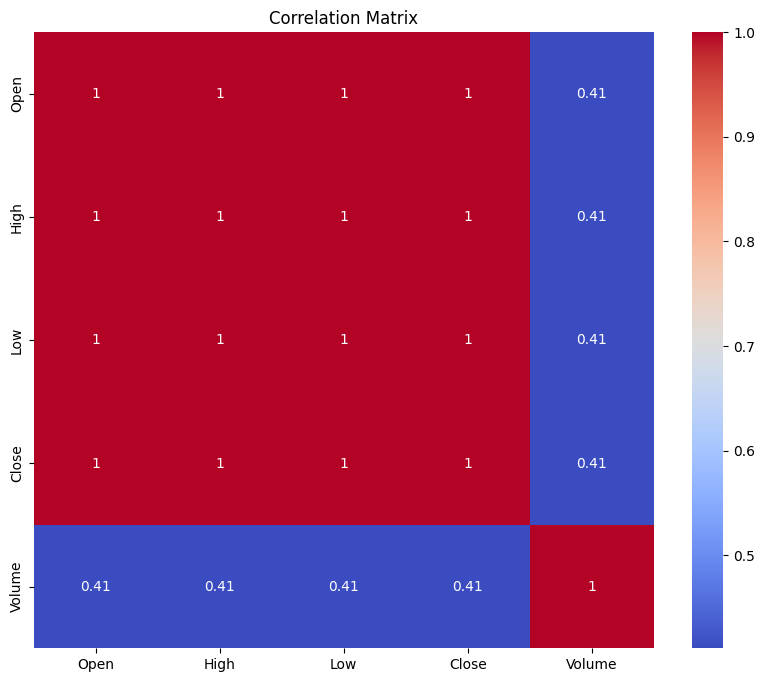

In [10]:
# 6. corr analysis
correlation_matrix = df[['Open', 'High', 'Low', 'Close', 'Volume']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [11]:
df.set_index('Datetime', inplace=True)

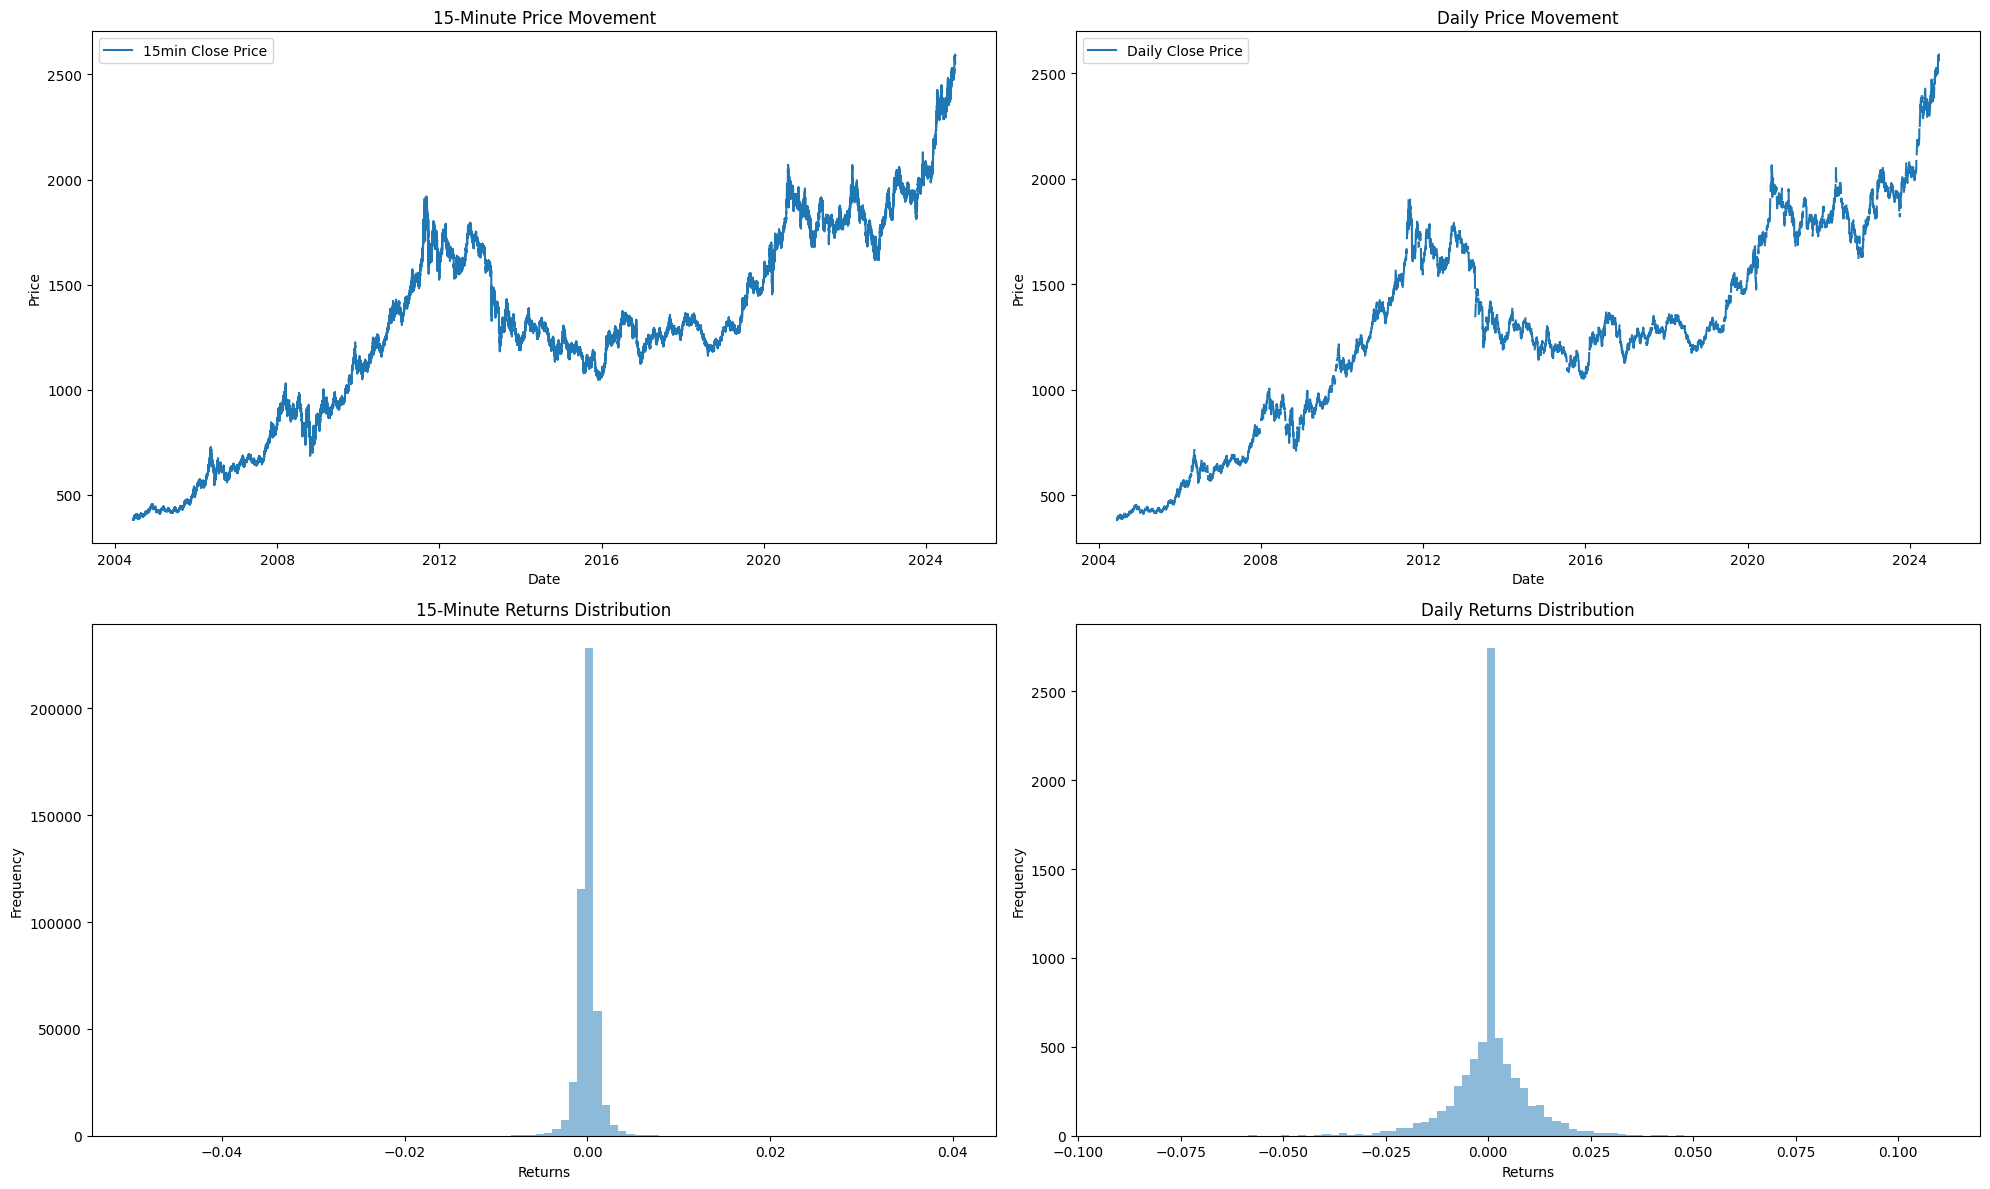


15-minute data statistics:
Data point count: 464737
Average volatility rate: 0.1151%
Maximum volatility: 4.0247%
Minimum volatility: -4.9731%

Daily data statistics:
Data point count: 7407
Average volatility rate: 0.9008%
Maximum volatility: 10.9897%
Minimum volatility: -9.0621%


In [38]:
# 1. Creating data with different time scales
# 15-minute data (original data)
df_15min = df.copy()

# Resampling to daily data
df_daily = df.resample('D').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
})

# 2. Visual comparison
fig = plt.figure(figsize=(20, 12))

# 15-minute data price movement
plt.subplot(2, 2, 1)
plt.plot(df_15min.index, df_15min['Close'], label='15min Close Price')
plt.title('15-Minute Price Movement')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Daily data price movement
plt.subplot(2, 2, 2)
plt.plot(df_daily.index, df_daily['Close'], label='Daily Close Price')
plt.title('Daily Price Movement')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# 15-minute data volatility
plt.subplot(2, 2, 3)
returns_15min = df_15min['Close'].pct_change()
plt.hist(returns_15min.dropna(), bins=100, alpha=0.5)
plt.title('15-Minute Returns Distribution')
plt.xlabel('Returns')
plt.ylabel('Frequency')

# Daily data volatility
plt.subplot(2, 2, 4)
returns_daily = df_daily['Close'].pct_change()
plt.hist(returns_daily.dropna(), bins=100, alpha=0.5)
plt.title('Daily Returns Distribution')
plt.xlabel('Returns')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# 3. Statistical comparison
print("\n15-minute data statistics:")
print(f"Data point count: {len(df_15min)}")
print(f"Average volatility rate: {returns_15min.std() * 100:.4f}%")
print(f"Maximum volatility: {returns_15min.max() * 100:.4f}%")
print(f"Minimum volatility: {returns_15min.min() * 100:.4f}%")

print("\nDaily data statistics:")
print(f"Data point count: {len(df_daily)}")
print(f"Average volatility rate: {returns_daily.std() * 100:.4f}%")
print(f"Maximum volatility: {returns_daily.max() * 100:.4f}%")
print(f"Minimum volatility: {returns_daily.min() * 100:.4f}%")





Lag correlation comparison:
15-minute data lag correlation: ['1.0000', '1.0000', '1.0000', '1.0000', '1.0000']
Daily data lag correlation: ['0.9996', '0.9992', '0.9990', '0.9989', '0.9987']


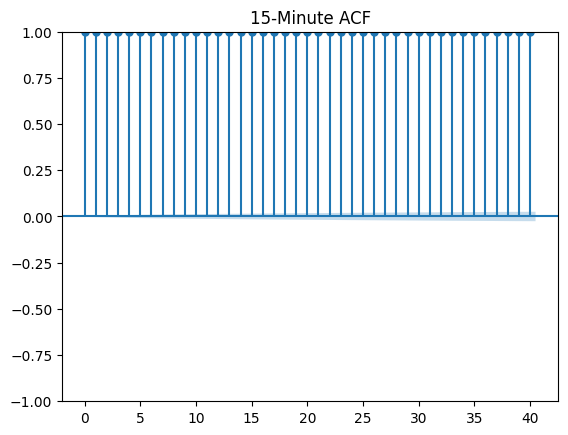

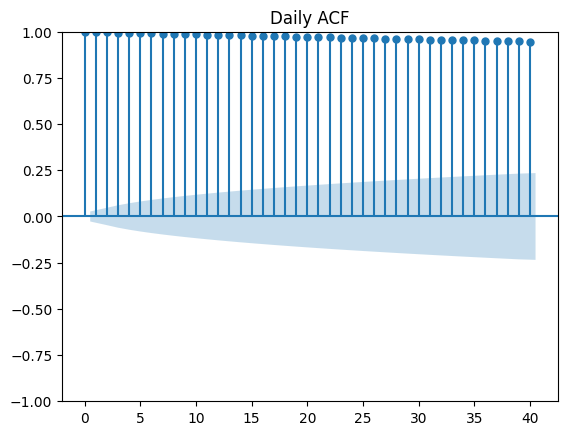

In [40]:

# 15-minute data autocorrelation
plot_acf(df_15min['Close'].dropna(), lags=40, title='15-Minute ACF')

# Daily data autocorrelation
plot_acf(df_daily['Close'].dropna(), lags=40, title='Daily ACF')



# Calculating prediction performance metrics for different time scales
def calculate_lag_correlation(data, lags=5):
    correlations = []
    for lag in range(1, lags + 1):
        correlation = data['Close'].corr(data['Close'].shift(lag))
        correlations.append(correlation)
    return correlations

corr_15min = calculate_lag_correlation(df_15min)
corr_daily = calculate_lag_correlation(df_daily)

print("\nLag correlation comparison:")
print("15-minute data lag correlation:", [f"{x:.4f}" for x in corr_15min])
print("Daily data lag correlation:", [f"{x:.4f}" for x in corr_daily])



We can find that daily data shows more meaningful price movements, while 15-minute data contains redundant information with perfect correlations.


In [12]:
df_daily = df.resample('D').agg({
    'Open': 'first',    
    'High': 'max',      
    'Low': 'min',       
    'Close': 'last',    
    'Volume': 'sum'     
})

df_daily = df_daily.dropna()

In [13]:
df_daily_final = df_daily.reset_index()
df_daily_final = df_daily_final.rename(columns={'Datetime': 'Date'})

In [14]:
df_daily_final.head()

,Date,Open,High,Low,Close,Volume
0,2004-06-11,384.0,384.8,382.8,384.1,272
1,2004-06-14,384.3,385.8,381.8,382.8,1902
2,2004-06-15,382.8,388.8,381.1,388.6,1951
3,2004-06-16,387.1,389.8,382.6,383.8,2014
4,2004-06-17,383.6,389.3,383.0,387.6,1568


## 3. Split the data

In [15]:
# we use 80% data to train, 20% to test
split_idx = int(len(df_daily_final) * 0.8)

train_df = df_daily_final[:split_idx]
test_df = df_daily_final[split_idx:]

In [16]:
train_df

,Date,Open,High,Low,Close,Volume
0,2004-06-11,384.00,384.80,382.80,384.10,272
1,2004-06-14,384.30,385.80,381.80,382.80,1902
2,2004-06-15,382.80,388.80,381.10,388.60,1951
3,2004-06-16,387.10,389.80,382.60,383.80,2014
4,2004-06-17,383.60,389.30,383.00,387.60,1568
...,...,...,...,...,...,...
4162,2020-09-02,1968.21,1973.26,1932.39,1943.08,115889
4163,2020-09-03,1942.01,1950.94,1921.75,1930.45,121698
4164,2020-09-04,1931.28,1948.36,1916.27,1933.09,122132
4165,2020-09-07,1932.07,1941.37,1924.44,1928.29,53826


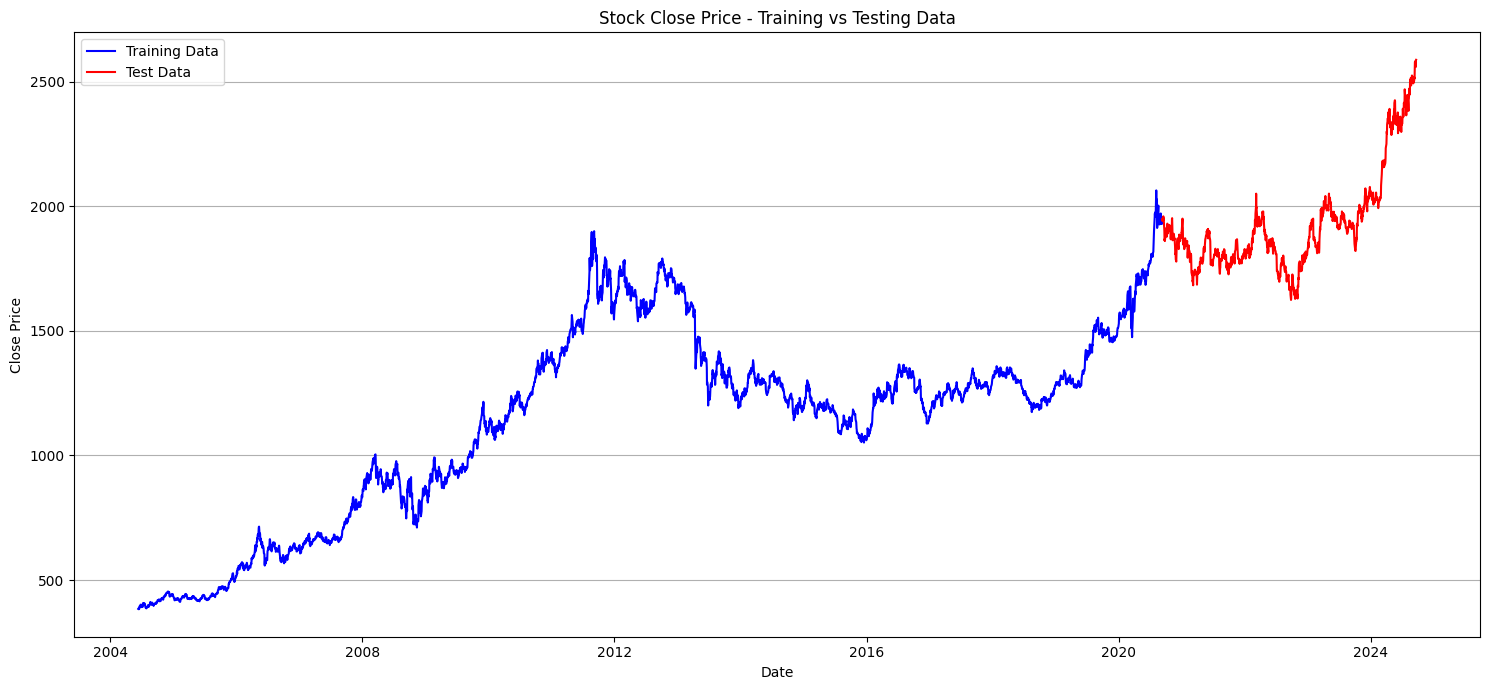

In [17]:
train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])

plt.figure(figsize=(15, 7))
plt.plot(train_df['Date'], train_df['Close'], label='Training Data', color='blue')
plt.plot(test_df['Date'], test_df['Close'], label='Test Data', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Stock Close Price - Training vs Testing Data')
plt.legend()
plt.grid(axis='y')

plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

## 4. Prepare the data for LSTM

In [18]:
all_data = pd.concat([train_df, test_df], axis=0)

In [19]:
all_data.tail(30)

,Date,Open,High,Low,Close,Volume
5179,2024-08-12,2427.95,2472.19,2423.86,2472.08,78973
5180,2024-08-13,2470.00,2476.99,2458.49,2465.43,80766
5181,2024-08-14,2465.77,2479.98,2438.12,2447.68,83873
5182,2024-08-15,2447.15,2470.06,2432.20,2456.21,78199
5183,2024-08-16,2455.69,2509.70,2450.74,2506.84,78600
5184,2024-08-19,2505.61,2507.50,2485.71,2504.33,83389
5185,2024-08-20,2503.60,2531.66,2497.33,2513.95,84646
5186,2024-08-21,2513.59,2519.91,2493.54,2511.33,79371
5187,2024-08-22,2511.73,2514.67,2470.87,2484.23,79813
5188,2024-08-23,2485.23,2518.26,2484.24,2511.23,80220


we need to scale the data, but we can just train scaler in trian data, not all data.

In [20]:
train_features = train_df[['Open', 'High', 'Low', 'Close', 'Volume']].values
scaler = MinMaxScaler()
scaler.fit(train_features)

MinMaxScaler()

In [21]:
def prepare_data(data, scaler, lookback=30):
    scaled_data = scaler.transform(data)
    
    X, y = [], []
    for i in range(len(scaled_data) - lookback):
        X.append(scaled_data[i:(i + lookback)])
        y.append(scaled_data[i + lookback])
    
    return np.array(X), np.array(y)


In [22]:
all_features = all_data[['Open', 'High', 'Low', 'Close', 'Volume']].values
X, y = prepare_data(all_features, scaler, lookback=30)

test_length = len(test_df)
X_test = X[-test_length:]
y_test = y[-test_length:]

# we use remaining data to train and val
remaining_X = X[:-test_length]
remaining_y = y[:-test_length]
train_size = int(len(remaining_X) * 0.8)

X_train = remaining_X[:train_size]
y_train = remaining_y[:train_size]

X_val = remaining_X[train_size:]
y_val = remaining_y[train_size:]

print("Shape of data:")
print("X_train:", X_train.shape)
print("X_val:", X_val.shape)
print("X_test:", X_test.shape)

Shape of data:
X_train: (3309, 30, 5)
X_val: (828, 30, 5)
X_test: (1042, 30, 5)


Show the close price of all data

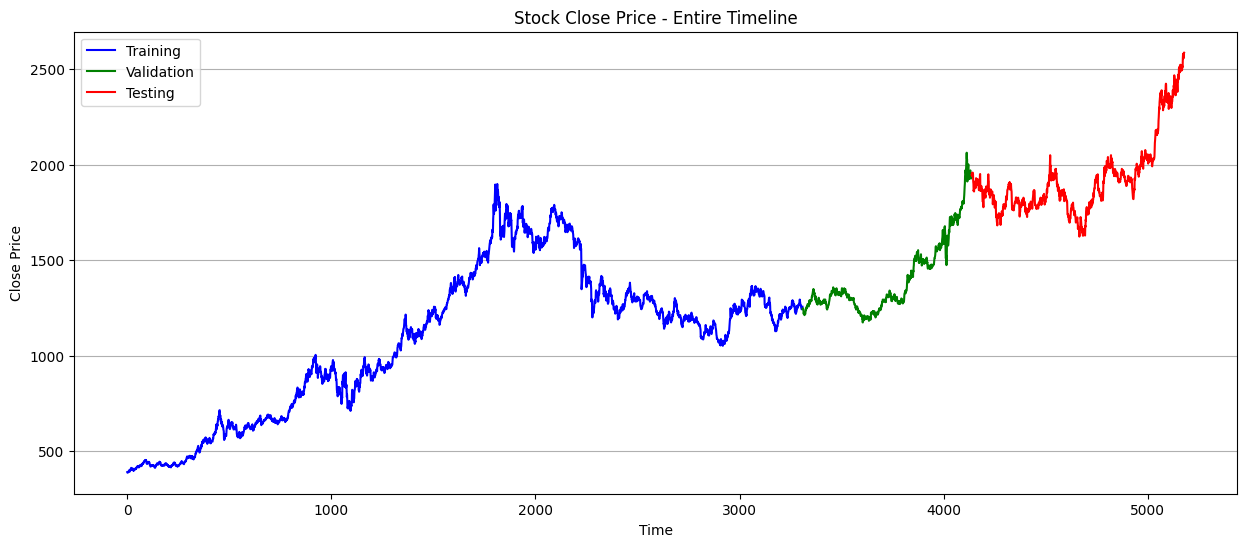

In [23]:

all_actual = scaler.inverse_transform(y)[:, 3]  # 3 is Close's index 3 is Close's index

# calculate the index of each part
train_size = len(X_train)
val_size = len(X_val)

# split data
train_data = all_actual[:train_size]
val_data = all_actual[train_size:train_size+val_size]
test_data = all_actual[train_size+val_size:]


plt.figure(figsize=(15, 6))
plt.plot(range(len(train_data)), train_data, label='Training', color='blue')
plt.plot(range(len(train_data), len(train_data)+len(val_data)), val_data, label='Validation', color='green')
plt.plot(range(len(train_data)+len(val_data), len(all_actual)), test_data, label='Testing', color='red')

plt.title('Stock Close Price - Entire Timeline')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.grid(axis='y')
plt.legend()
plt.show()

check our data

In [24]:
def inspect_data(X, y, scaler, sample_index=0, days_to_show=5, name="Dataset"):
    """
    The function to check the time series data
    
    Parameters: 
    X: input data (sample number, time steps, feature number)
    y: target data (sample number, feature number)
    scaler: scaler for inverse normalization
    sample_index: sample index to inspect
    days_to_show: days to show
    name: dataset name (e.g. "Training", "Test")
    """
    print(f"\n=== Inspecting {name} Data ===")
    print(f"Total samples: {len(X)}")
    print(f"\nSample {sample_index} shape:")
    print(f"X shape: {X[sample_index].shape}")
    print(f"y shape: {y[sample_index].shape}")
    
    print(f"\nFirst {days_to_show} days of input sequence (normalized):")
    print(X[sample_index][:days_to_show])
    
    print("\nTarget (normalized):")
    print(y[sample_index])
    
    # inverse normalization
    original_X = scaler.inverse_transform(X[sample_index][0].reshape(1, -1))
    original_y = scaler.inverse_transform(y[sample_index].reshape(1, -1))
    
    print("\nFirst day data in original scale:")
    print("Features (Open, High, Low, Close, Volume):", original_X[0])
    print("Target in original scale:", original_y[0])

# check training data
inspect_data(X_train, y_train, scaler, sample_index=0, name="Training")

# check test data
inspect_data(X_test, y_test, scaler, sample_index=0, name="Test")


=== Inspecting Training Data ===
Total samples: 3309

Sample 0 shape:
X shape: (30, 5)
y shape: (5,)

First 5 days of input sequence (normalized):
[[0.00071269 0.         0.00102822 0.0007736  0.00039762]
 [0.00089087 0.00059169 0.00042339 0.         0.00279808]
 [0.         0.00236677 0.         0.00345146 0.00287024]
 [0.00255382 0.00295846 0.00090725 0.00059508 0.00296302]
 [0.00047513 0.00266261 0.00114919 0.00285638 0.00230621]]

Target (normalized):
[0.00386043 0.00431935 0.00423385 0.00416555 0.00293062]

First day data in original scale:
Features (Open, High, Low, Close, Volume): [384.  384.8 382.8 384.1 272. ]
Target in original scale: [ 389.3  392.1  388.1  389.8 1992. ]

=== Inspecting Test Data ===
Total samples: 1042

Sample 0 shape:
X shape: (30, 5)
y shape: (5,)

First 5 days of input sequence (normalized):
[[0.93800148 0.94431    0.94368369 0.94499688 0.16305003]
 [0.94327543 0.93873035 0.94254055 0.93709423 0.18374993]
 [0.93404603 0.94621525 0.9521514  0.94749621 0.1

## 5. LSTM model

In [25]:
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(units=128, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(units=64, return_sequences=True),
        Dropout(0.2),
        LSTM(units=32, return_sequences=False),
        Dropout(0.2),
        Dense(units=32),
        Dense(units=5)
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='mse',
                 metrics=['mae', 'mape'])
    
    return model

# create model
input_shape = (30, 5)  # (time steps, feature number) 
model_base = build_lstm_model(input_shape)

model_base.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 128)        │        68,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131,653 (514.27 KB)

 Trainable params: 131,653 (514.27 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
early_stopping = EarlyStopping(
    monitor='val_loss',      # monitor validation loss
    patience=20,             # if no improvement in 20 epochs, stop
    mode='min',             
    restore_best_weights=True  # restore best weights
)

model_checkpoint = ModelCheckpoint(
    'best_model.keras',        
    monitor='val_loss',
    save_best_only=True,    
    mode='min',
    verbose=1
)



# train model
history_base = model_base.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

Epoch 1/100
103/104 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0323 - mae: 0.1124 - mape: 150.1535
Epoch 1: val_loss improved from inf to 0.00170, saving model to best_model.keras
104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.0319 - mae: 0.1115 - mape: 151.4835 - val_loss: 0.0017 - val_mae: 0.0263 - val_mape: 9.5880
Epoch 2/100
103/104 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0039 - mae: 0.0440 - mape: 226.3212
Epoch 2: val_loss improved from 0.00170 to 0.00134, saving model to best_model.keras
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0039 - mae: 0.0440 - mape: 232.2296 - val_loss: 0.0013 - val_mae: 0.0289 - val_mape: 9.5890
Epoch 3/100
102/104 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0029 - mae: 0.0372 - mape: 45.5407
Epoch 3: val_loss did not improve from 0.00134
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0029 - mae: 0.0372 - mape: 45.8545 - val_loss: 0.0018 - val_mae: 0.0379 - val_mape: 11.8837
Epoch 4/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - 

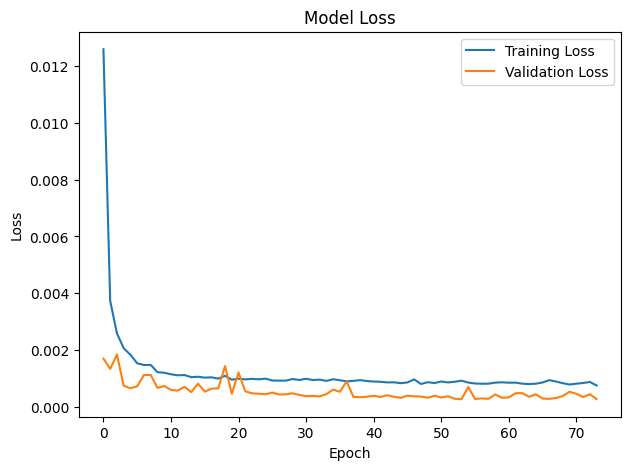

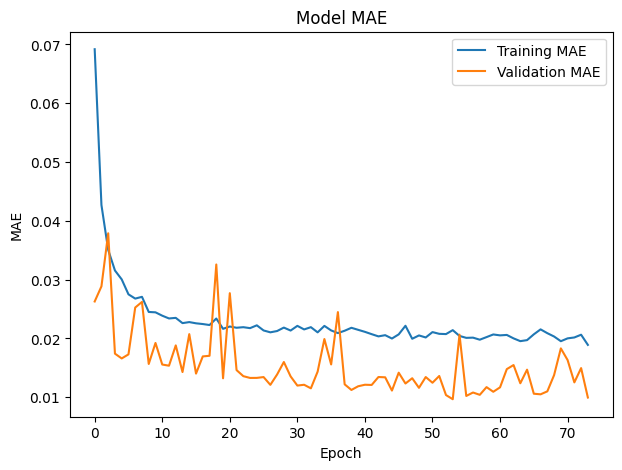

In [27]:
def plot_training_history_separately(history):
    # Plot loss curve
    plt.figure(figsize=(7, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Plot MAE curve
    plt.figure(figsize=(7, 5))
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Model MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.show()

plot_training_history_separately(history_base)

In [28]:
test_loss_base, test_mae_base, test_mape_base = model_base.evaluate(X_test, y_test, verbose=0)

print("\nTest Set Performance (Normalized Scale):")
print(f"Loss (MSE): {test_loss_base:.6f}")
print(f"MAE: {test_mae_base:.6f}")
print(f"MAPE: {test_mape_base:.6f}")


Test Set Performance (Normalized Scale):
Loss (MSE): 0.000879
MAE: 0.015910
MAPE: 5.547914


In [20]:
test_loss_base, test_mae_base, test_mape_base = model_base.evaluate(X_test, y_test, verbose=0)

print("\nTest Set Performance (Normalized Scale):")
print(f"Loss (MSE): {test_loss_base:.6f}")
print(f"MAE: {test_mae_base:.6f}")
print(f"MAPE: {test_mape_base:.6f}")


Test Set Performance (Normalized Scale):
Loss (MSE): 0.000772
MAE: 0.014275
MAPE: 5.273886


In [29]:
test_loss_base, test_mae_base, test_mape_base = model_base.evaluate(X_test, y_test, verbose=0)

print("\nTest Set Performance (Normalized Scale):")
print(f"Loss (MSE): {test_loss_base:.6f}")
print(f"MAE: {test_mae_base:.6f}")
print(f"MAPE: {test_mape_base:.6f}")


Test Set Performance (Normalized Scale):
Loss (MSE): 0.000879
MAE: 0.015910
MAPE: 5.547914


## 6. Evaluate

In [30]:
best_model_tuned = model_base

# get predictions
predictions_test = best_model_tuned.predict(X_test)

# convert back to original scale
predictions_original_test = scaler.inverse_transform(predictions_test)
actual_original_test = scaler.inverse_transform(y_test)

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


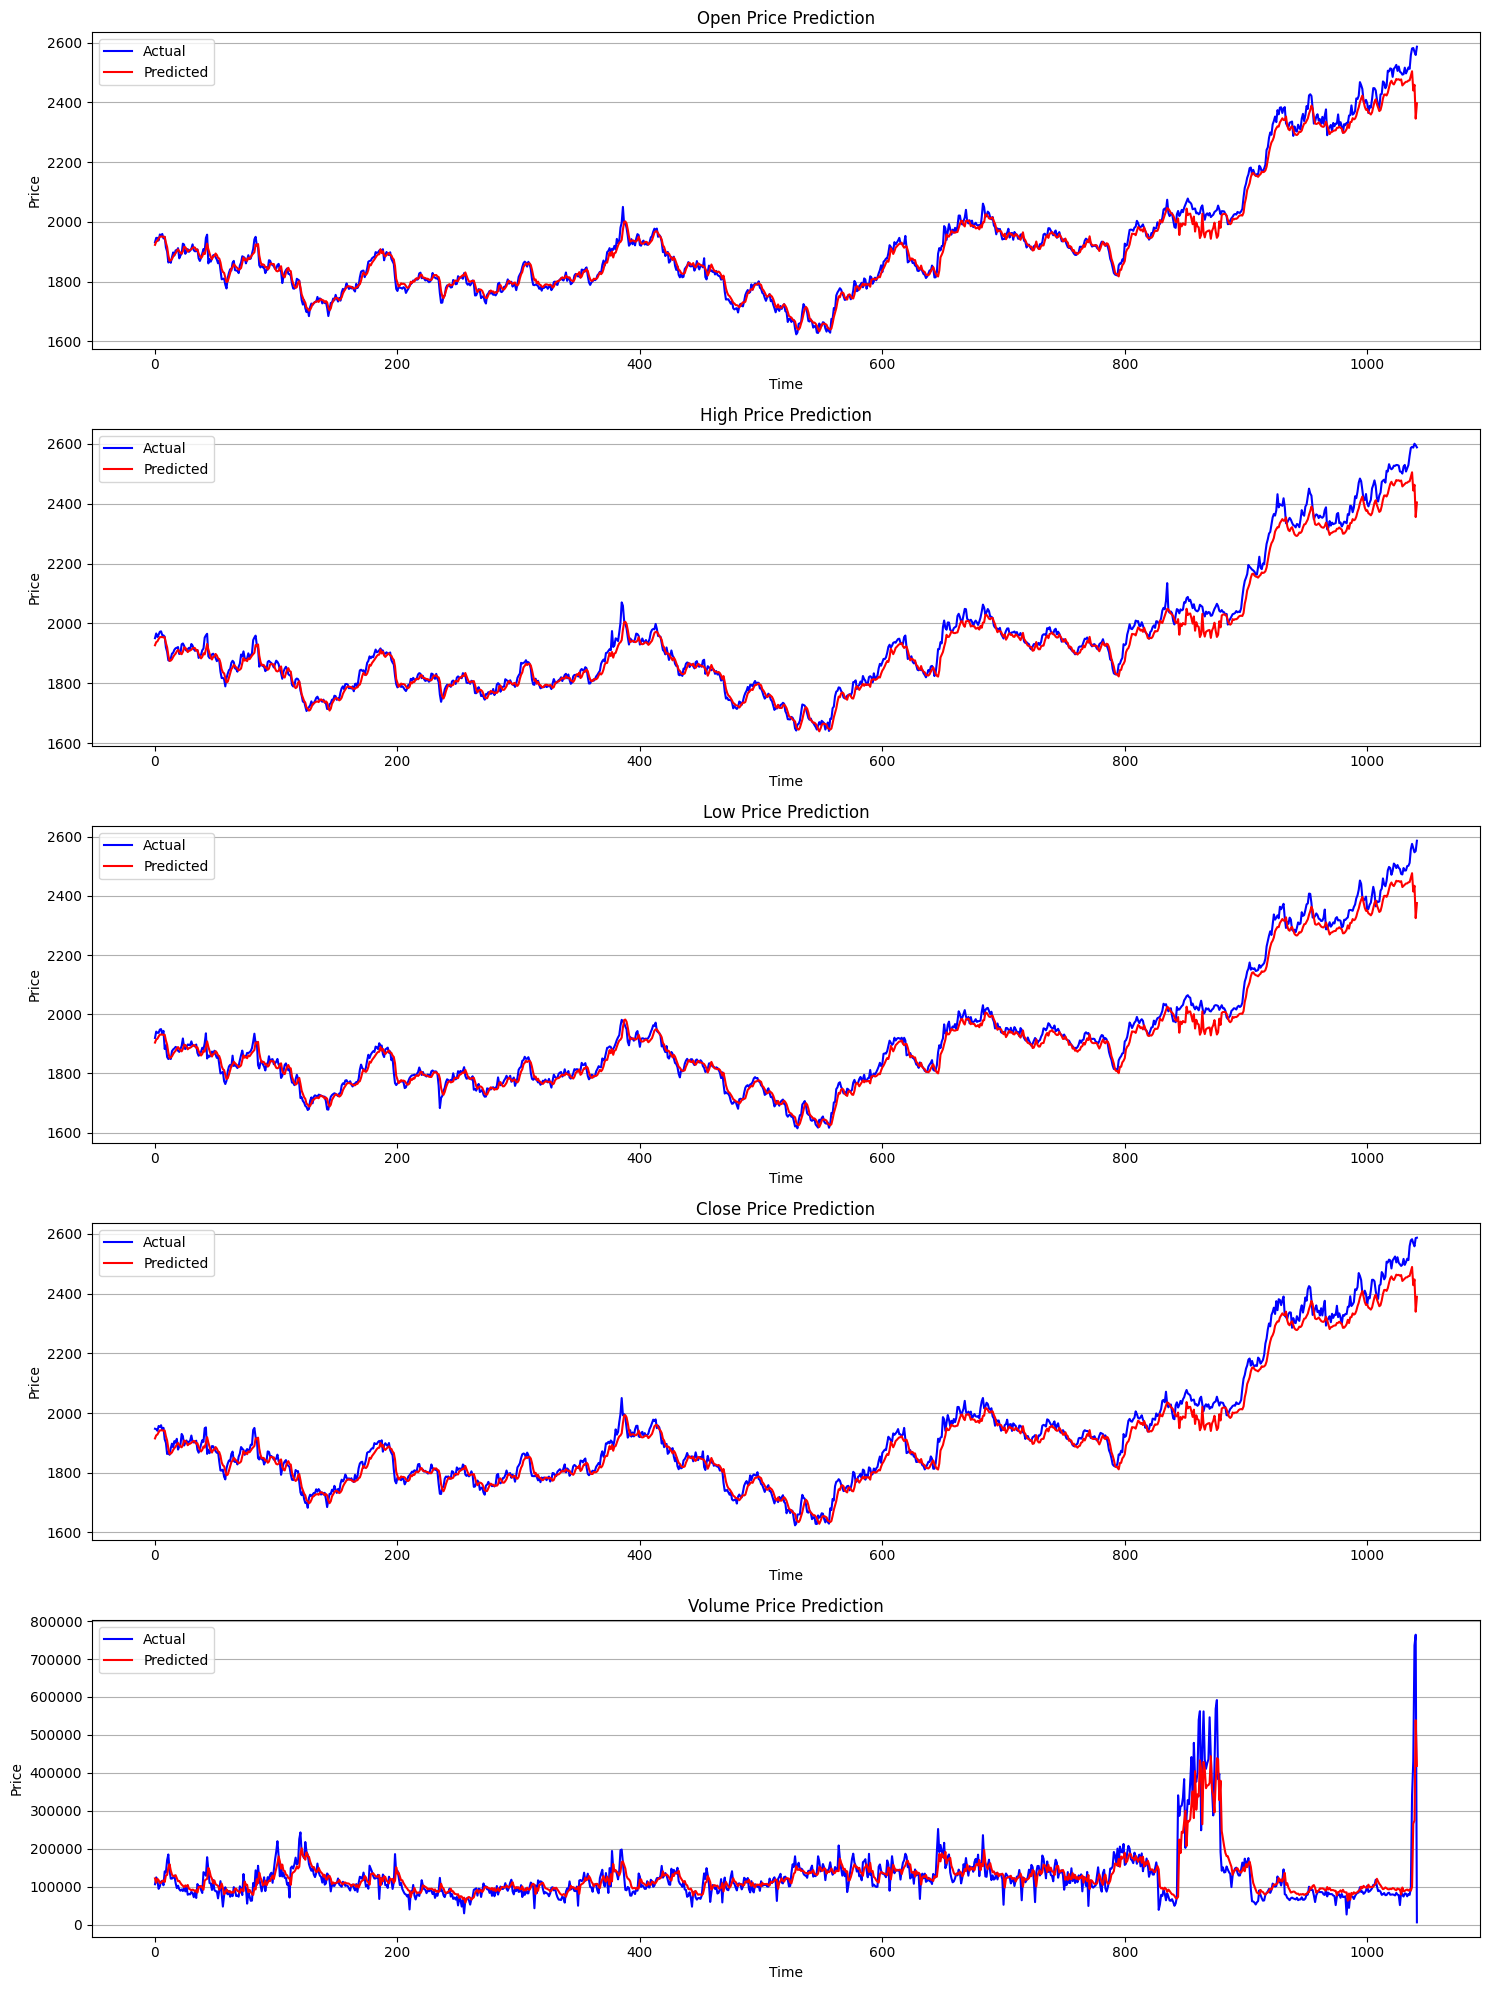

In [31]:

fig, axes = plt.subplots(5, 1, figsize=(15, 20))
features = ['Open', 'High', 'Low', 'Close', 'Volume']

for i, (ax, feature) in enumerate(zip(axes, features)):
    ax.plot(actual_original_test[:, i], label='Actual', color='blue')
    ax.plot(predictions_original_test[:, i], label='Predicted', color='red')
    ax.set_title(f'{feature} Price Prediction')
    ax.set_xlabel('Time')
    ax.set_ylabel('Price')
    ax.legend()
    ax.grid(axis='y')

plt.tight_layout()
plt.show()

In [32]:
# calculate MAE, RMSE and MAPE
mae = np.mean(np.abs(predictions_original_test - actual_original_test), axis=0)
rmse = np.sqrt(np.mean((predictions_original_test - actual_original_test) ** 2, axis=0))
mape = np.mean(np.abs((actual_original_test - predictions_original_test) / actual_original_test), axis=0) * 100

features = ['Open', 'High', 'Low', 'Close', 'Volume']
print("\nModel Performance on Test Set (Original Scale):")

print("\nMean Absolute Error (MAE):")
for feature, mae_value in zip(features, mae):
    print(f"{feature}: {mae_value:.2f}")

print("\nRoot Mean Squared Error (RMSE):")
for feature, rmse_value in zip(features, rmse):
    print(f"{feature}: {rmse_value:.2f}")

print("\nMean Absolute Percentage Error (MAPE):")
for feature, mape_value in zip(features, mape):
    print(f"{feature}: {mape_value:.2f}%")


Model Performance on Test Set (Original Scale):

Mean Absolute Error (MAE):
Open: 16.53
High: 21.57
Low: 20.94
Close: 23.99
Volume: 20391.92

Root Mean Squared Error (RMSE):
Open: 24.46
High: 31.32
Low: 29.48
Close: 33.36
Volume: 37993.27

Mean Absolute Percentage Error (MAPE):
Open: 0.83%
High: 1.06%
Low: 1.05%
Close: 1.20%
Volume: 22.61%


We want to see the performance on the entire timeline.

162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


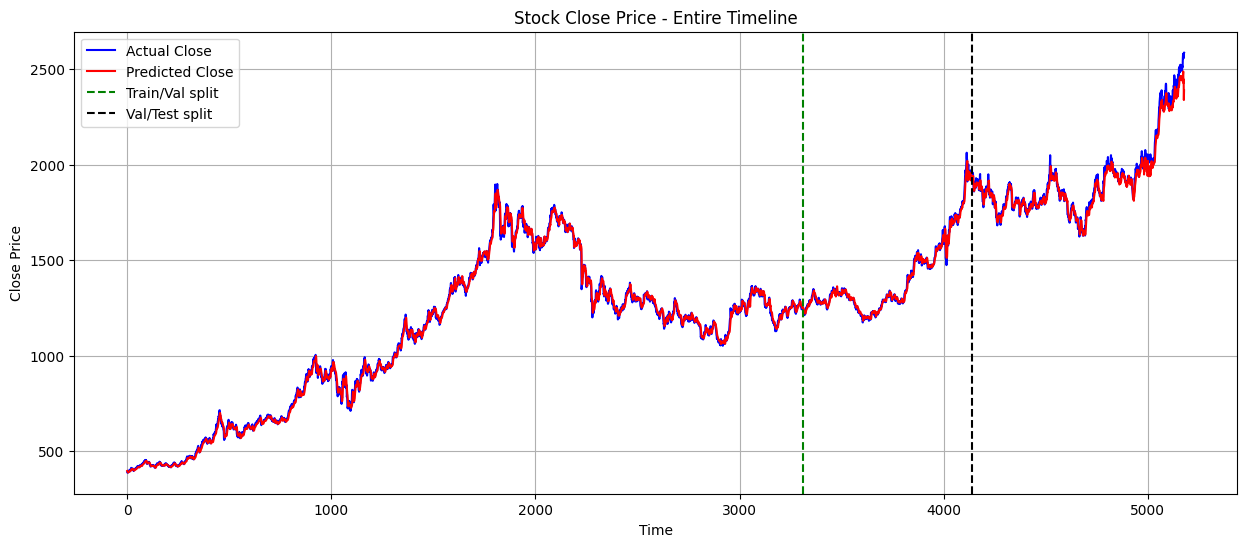

In [33]:
# predict on all data
predictions_all = best_model_tuned.predict(X)  # use all X data
predictions_all_original = scaler.inverse_transform(predictions_all)
actual_all_original = scaler.inverse_transform(y)

# plot the comparison of Close price
plt.figure(figsize=(15, 6))
plt.plot(actual_all_original[:, 3], label='Actual Close', color='blue')
plt.plot(predictions_all_original[:, 3], label='Predicted Close', color='red')

# add vertical lines to mark the split of training, validation and test set
train_size = len(X_train)
val_size = len(X_val)
plt.axvline(x=train_size, color='g', linestyle='--', label='Train/Val split')
plt.axvline(x=train_size+val_size, color='k', linestyle='--', label='Val/Test split')

plt.title('Stock Close Price - Entire Timeline')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()